# Cyclist - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [3]:
dataset = pd.read_csv('../../data/complete_dataset_fe.csv', dtype={'cyclist_team': str})
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d')

In [4]:
'''
Clustering Features Cyclists:
-'cyclist_bmi', 
-'cyclist_age', 
-'height', 
-'cyclist_climb_power', 
-'position', 
-'delta'
'''

"\nClustering Features Cyclists:\n-'cyclist_bmi', \n-'cyclist_age', \n-'height', \n-'cyclist_climb_power', \n-'position', \n-'delta'\n"

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 589739 entries, 0 to 589738
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   cyclist_url                   589739 non-null  object        
 1   cyclist_name                  589739 non-null  object        
 2   birth_year                    589739 non-null  int64         
 3   weight                        480007 non-null  float64       
 4   height                        480007 non-null  float64       
 5   nationality                   589739 non-null  object        
 6   race_url                      589739 non-null  object        
 7   race_name                     589739 non-null  object        
 8   points                        589739 non-null  float64       
 9   uci_points                    422184 non-null  float64       
 10  length                        589739 non-null  float64       
 11  climb_total  

In [6]:
columns_to_use = ['mean_bmi','mean_height', 'mean_cp', 'mean_position', 'mean_delta']

# Step 1: Calculate the mean delta for each cyclist

mean_pos = dataset.groupby('cyclist_url')['position'].mean()
mean_bmi = dataset.groupby('cyclist_url')['cyclist_bmi'].mean() # fixed
mean_height = dataset.groupby('cyclist_url')['height'].mean() # fixed

weighted_mean_cp = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['cyclist_climb_power'] * group['climb_percentage']).sum() / group['climb_percentage'].sum()
    )
)


group_sizes = dataset.groupby('cyclist_url').size()
dataset['group_size'] = dataset['cyclist_url'].map(group_sizes)
dataset['delta_weight'] = dataset['group_size']  # Weight is inversely proportional to group size
weighted_mean_delta = (
    dataset.groupby('cyclist_url').apply(
        lambda group: (group['delta'] * group['weight']).sum() / group['weight'].sum()
    )
)

# Step 2: Map the mean delta back to each row
dataset['mean_delta'] = dataset['cyclist_url'].map(weighted_mean_delta)
dataset['mean_position'] = dataset['cyclist_url'].map(mean_pos)
dataset['mean_bmi'] = dataset['cyclist_url'].map(mean_bmi)
dataset['mean_height'] = dataset['cyclist_url'].map(mean_height)
dataset['mean_cp'] = dataset['cyclist_url'].map(weighted_mean_cp)


dataset = dataset[['cyclist_url', 'mean_bmi', 'mean_height', 'mean_cp', 'mean_position', 'mean_delta']].drop_duplicates()
dataset = dataset[['mean_bmi', 'mean_height', 'mean_cp', 'mean_position', 'mean_delta']]


/tmp/ipykernel_15592/3082767116.py:11: RuntimeWarning: invalid value encountered in scalar divide
  lambda group: (group['cyclist_climb_power'] * group['climb_percentage']).sum() / group['climb_percentage'].sum()
/tmp/ipykernel_15592/3082767116.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset.groupby('cyclist_url').apply(
/tmp/ipykernel_15592/3082767116.py:21: RuntimeWarning: invalid value encountered in scalar divide
  lambda group: (group['delta'] * group['weight']).sum() / group['weight'].sum()
/tmp/ipykernel_15592/3082767116.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the groupin

In [7]:
weighted_mean_cp

cyclist_url
aad-van-den-hoek      0.000932
aaron-gate            0.002571
aaron-kemps           0.004649
aaron-olsen           0.000000
aaron-van-poucke      0.000047
                        ...   
zenon-jaskula         0.003164
zhandos-bizhigitov    0.000055
zico-waeytens         0.001403
zoran-klemencic       0.001654
zsolt-der             0.000000
Length: 6095, dtype: float64

In [8]:
data_for_clustering = dataset.dropna() #TODO: remove when we have imputed the missing values

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

#### Model Selection

In [9]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value?
    
    #print("k = ", k)
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))
    
    #print("sorted_distances = ", sorted_distances)
    #print("indices = ", indices)

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

    #print("kneedle.knee = ", kneedle.knee)
    
    if(kneedle.knee is None):
        optimal_eps.append(None)  # The y-value at the knee
        optimal_index.append(None)  # The x-value (index)
        silhouette_scores.append(None)
        continue
    
    # Get the knee (optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    data_for_clustering['cluster'] = clusters
    number_of_clusters = data_for_clustering['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster is that of outliers, to compite silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

/tmp/ipykernel_15592/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_15592/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters
/tmp/ipykernel_15592/2745289044.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,1.587192,3037,7,0.788435
1,3,1.246551,2983,4,0.834334
2,4,1.716946,3020,3,0.915501
3,5,2.282782,3036,2,NaN
4,6,2.650118,3042,2,NaN
5,7,2.655873,3039,2,NaN
6,8,2.103742,3018,2,NaN
7,9,1.818619,3001,2,NaN
8,10,1.627425,2981,2,NaN
9,11,2.436837,3025,2,NaN


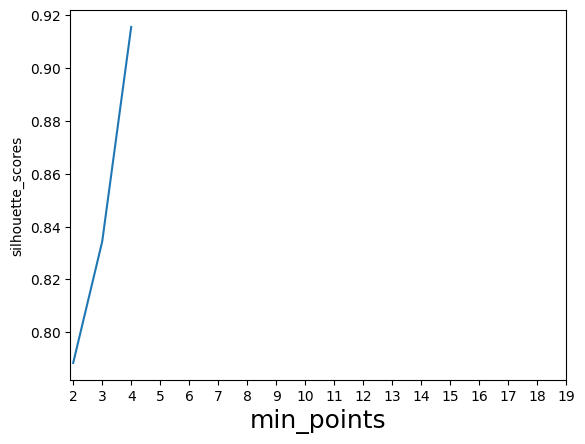

In [10]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameter Clustering

(4680270,)
(3060, 3060)
Optimal epsilon (eps): 1.7169461179596783
Knee point index: 3020


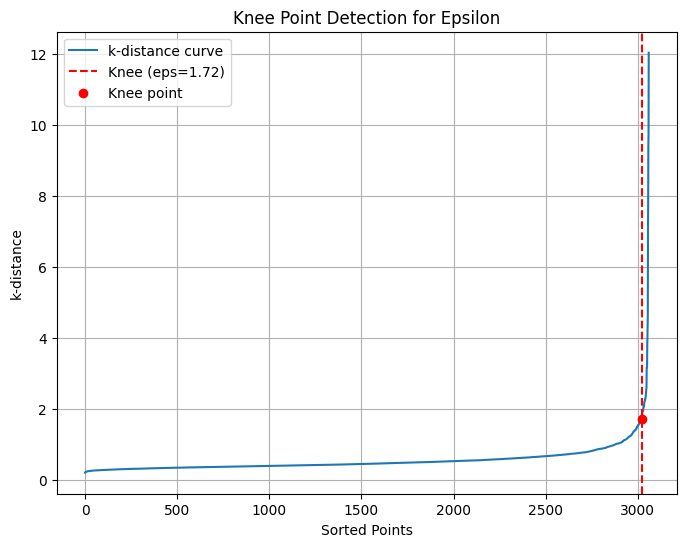

In [11]:
min_points = 4

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [12]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
data_for_clustering['cluster'] = clusters

# Display cluster distribution
print(data_for_clustering['cluster'].value_counts())
print(data_for_clustering.head())

cluster
 0    3032
-1      25
 1       3
Name: count, dtype: int64
      mean_bmi  mean_height   mean_cp  mean_position  mean_delta  cluster
0    22.256908        186.0  0.000932       0.707648  398.568966        0
58   21.672110        181.0  0.002571       0.620541  847.935484        0
89   22.282592        181.0  0.004649       0.467297  404.819672        0
196  21.705129        177.0  0.000047       0.666310  458.285714        0
203  20.756387        181.0  0.000032       0.828177  559.000000        0


/tmp/ipykernel_15592/4157897731.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_clustering['cluster'] = clusters


In [13]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0,  1]), array([  25, 3032,    3]))

In [14]:
# Identify outliers (cluster label -1)
outliers = data_for_clustering[data_for_clustering['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 25


In [15]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = data_for_clustering.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
           mean_bmi           mean_height             mean_cp            \
              mean       std        mean       std      mean       std   
cluster                                                                  
-1       21.503541  1.552074  179.600000  8.401389  0.026717  0.032378   
 0       21.189076  1.347456  179.879947  6.431485  0.002477  0.003127   
 1       21.125922  1.116839  179.000000  1.000000  0.039970  0.004109   

        mean_position             mean_delta               
                 mean       std         mean          std  
cluster                                                    
-1           0.654304  0.193484  1765.261369  1797.850272  
 0           0.577326  0.156919   514.296551   226.970420  
 1           0.492717  0.032958   318.504404   109.637056  


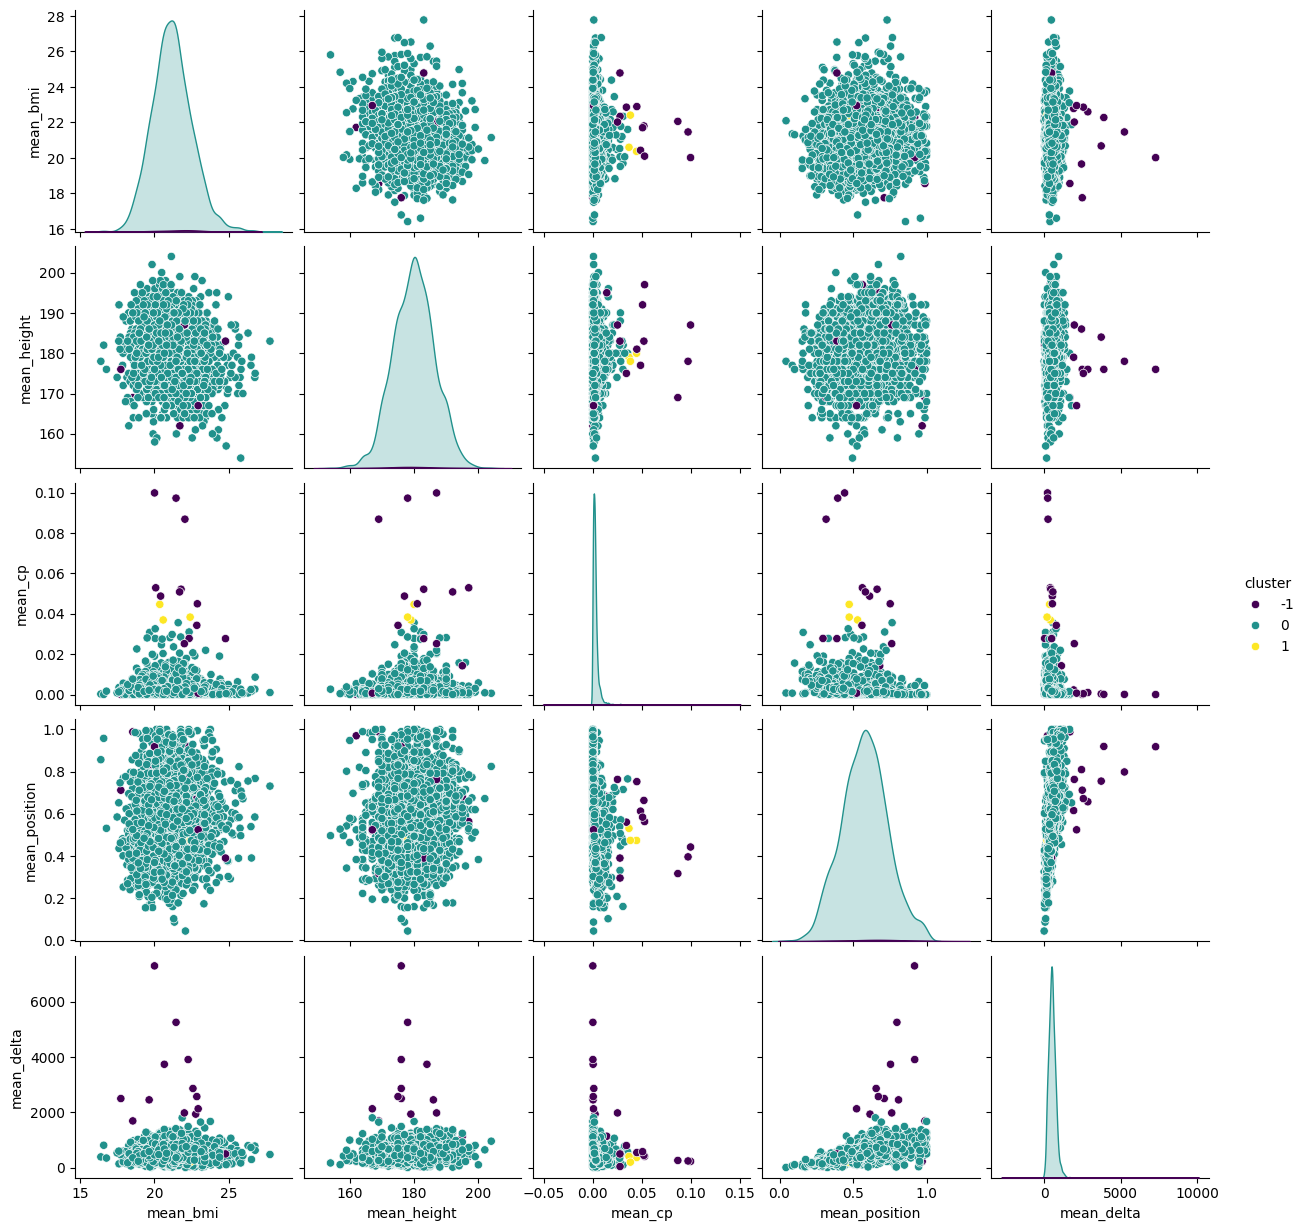

In [16]:

# Pair plot for a subset of columns
data_subset = data_for_clustering[columns_to_use + ["cluster"]]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

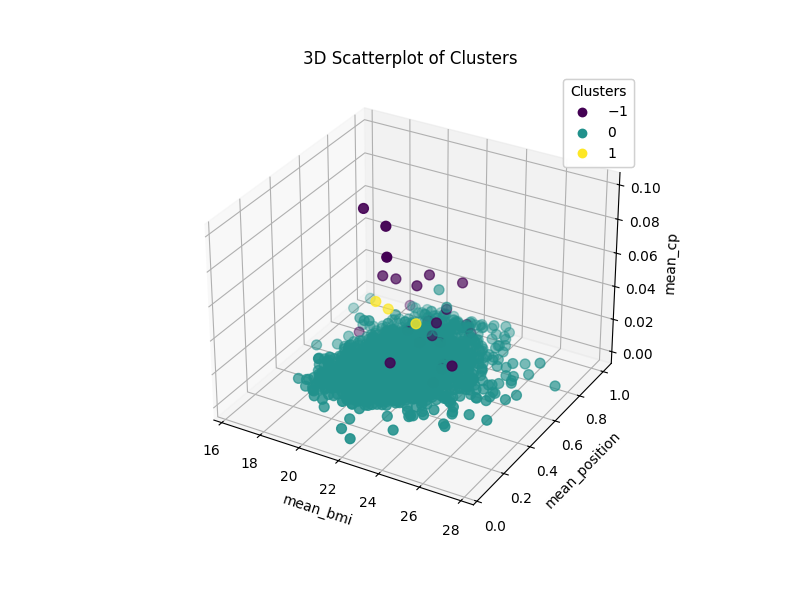

In [17]:
%matplotlib widget

x = data_for_clustering['mean_bmi']  # Prima feature
y = data_for_clustering['mean_position']  # Seconda feature
z = data_for_clustering['mean_cp']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=data_for_clustering['cluster'], cmap='viridis', s=50)
ax.set_xlabel('mean_bmi')
ax.set_ylabel('mean_position')
ax.set_zlabel('mean_cp')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

In [18]:
data_scaled = scaler.fit_transform(data_for_clustering[data_for_clustering['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

Silhouette 0.9155010734320925
